In [32]:
from federated_learning.dataloader import MNISTDataloader
from federated_learning.configuration import Configuration
import torch 


In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
# Configuration 

n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [25]:
config = Configuration()
mnist = MNISTDataloader(config)
examples = enumerate(mnist.train_dataloader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape


MNIST training loader loaded.
MNIST test loader loaded.


torch.Size([64, 1, 28, 28])

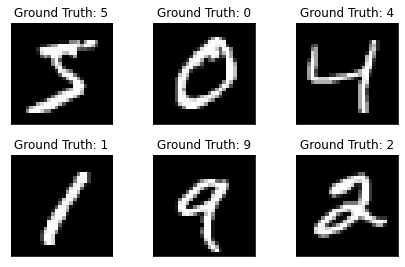

In [18]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

# Train Model

## Network

In [28]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [29]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [34]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [36]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(mnist.train_dataloader.dataset) for i in range(n_epochs)]

In [48]:
# Train and Test Funktions
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(mnist.train_dataloader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), len(mnist.train_dataloader.dataset),100. * batch_idx / len(mnist.train_dataloader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(mnist.train_dataloader.dataset)))
            torch.save(network.state_dict(), './results/model.pth')
            torch.save(optimizer.state_dict(), './results/optimizer.pth')

def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in mnist.test_dataloader:
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(mnist.test_dataloader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(mnist.test_dataloader.dataset), 100. * correct / len(mnist.test_dataloader.dataset)))

In [49]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

/tmp/ipykernel_4776/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 0.1041, Accuracy: 9666/10000 (97%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.193441
Train Epoch: 1 [640/60000 (1%)]	Loss: 0.171581
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.321164
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.408518
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.230788
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.137324
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.304410
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.466659
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.423950
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.216544
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.325618
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.164347
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.159622
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.294066
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.150458
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.402324
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.609523
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.191997
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.354672
Train Epoch: 1 [12160